# **CDS Project: Part 3**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Choose an ML model architecture for vulnerability prediction
- Preprocess the dataset you created in project part 2 to fit the model you selected
- Split the dataset for cross validation
- Create the model training pipeline, train the model using the train set and optimize the model using the test set
- Create loss graphs of the learning behaviour
- Generate predictions for the validation set
- Evaluate the results using appropriate metrics (add questions: reduce overfitting? optional 5-fold cross validation)


## Materials
---

- Lecture Slides 2, 3, 5 and 6, 9.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- 


## Project Description

In this project, you will create, train and evaluate your own machine learning model to predict vulnerabilities in source code. In addition, you will preprocess the data to prepare it to be used in the learning pipeline.
You will be using the dataset created in part 2 in this part. 

## **Task 1**

- There are several ML model architectures that you can use for vulnerabilitiy prediction such as RNN, CNN, Multilabel Perceptron (MLP), Gated Recurrent Units (GRU) and so on. Choose a suitable ML model architecture for your project based on the strenghts and weaknesses of these algorithms.

- For the model architecture, you can choose from 2 paths:
  1. Preprocess the functions into vectors and continue the learning process similar to project 1.
  For instance, the code in the dataset needs to be converted into some type of vector representation that can be processed by a machine. After selecting a suitable model, preprocess the content in your dataset accordingly. Several models are available to preprocess code data such as:
    - Code2Vec: https://code2vec.org/
    - CodeBERT: https://github.com/microsoft/CodeBERT/tree/master/UniXcoder
    - CodeT5: https://github.com/salesforce/CodeT5

  2. Choose a model architecture that is capable of handeling raw text inputs (LSTM, GRU, etc.) as an input layer. Further information on text processing using pytorch:
    - https://pytorch.org/text/stable/index.html
    - https://pytorch.org/tutorials/


In [ ]:



    
    # Initialize model
    model = VulnerabilityLSTM(
        vocab_size=len(vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=1
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop (Task 3)
    train_losses = []
    val_losses = []
    
    print("Starting training...")
    for epoch in range(EPOCHS):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        val_loss, _, _ = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Plot loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()
    
    # Evaluate on test set
    test_loss, test_labels, test_preds = evaluate_model(model, test_loader, criterion)
    print("\nTest Results:")
    print(classification_report(test_labels, test_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, test_preds))
    
    # Save model
    torch.save(model.state_dict(), 'vulnerability_model.pth')

In [9]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

In [10]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Parameters
MAX_LEN = 256           # Maximum sequence length
BATCH_SIZE = 32         # Batch size
EMBEDDING_DIM = 128     # Word embedding dimension
HIDDEN_DIM = 128        # LSTM hidden dimension
EPOCHS = 10             # Training epochs
LEARNING_RATE = 0.001   # Learning rate

In [33]:
class CodeDataset(Dataset):
    def __init__(self, functions, labels, vocab, max_len):
        self.functions = functions
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.functions)
    
    def __getitem__(self, idx):
        function = self.functions[idx]
        # Convert text to sequence of indices
        sequence = [self.vocab.get(char, self.vocab["<UNK>"]) for char in function][:self.max_len]
        # Padding
        padded = sequence + [self.vocab["<PAD>"]] * (self.max_len - len(sequence))
        return {
            "input_ids": torch.tensor(padded, dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Load dataset
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    functions = []
    labels = []
    
    for item in data:
        functions.append(item['function_code'])
        # Convert labels: vulnerable=1, fixed=0
        labels.append(1 if item['is_vulnerable'] else 0)
    
    return functions, labels

# Build vocabulary
def build_vocab(functions):
    counter = Counter()
    for func in functions:
        counter.update(func)
    
    vocab = {
        "<PAD>": 0,
        "<UNK>": 1,
        **{char: idx+2 for idx, char in enumerate(counter)}
    }
    return vocab

## Task 2

- Split your dataset appropriately into train, test, and validation set and justify your split.  

In [27]:
# TODO: Load the dataset
functions, labels = load_dataset("/home/mayank-nagar/Documents/Sommer semester/Cybersecurity for Data Science/PBL_-Projekt-problembasierte_Lehrveranstaltung_Cybersecurity_Data_Science_PBL/Part_2/labeled_methods_dataset.json")
vocab = build_vocab(functions)

# TODO: Split the dataset into train, test and validation set
def split_dataset(functions, labels):
    # Initial split: 80% train, 20% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        functions, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels
    )
    # Split temp into validation and test (50/50)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [34]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(functions, labels)

# Create datasets and dataloaders
train_dataset = CodeDataset(X_train, y_train, vocab, MAX_LEN)
val_dataset = CodeDataset(X_val, y_val, vocab, MAX_LEN)
test_dataset = CodeDataset(X_test, y_test, vocab, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Task 3
- Create a preprocessing and training/test pipeline. This can also be done in separate steps.
- Train the model on a small dataset (e.g.: 1000 samples depending on the computational capacity) and make sure everything is working properly
- Show a graph showing the changes in loss function druring the training epochs 
- Select proper metrics to evaluate the performance of the model
- If everything works well, then change the model parameters (e.g: number of neurons, layer depth) and regenerate the results. Comapare these results with your previous results and elaborate your findings.

In [35]:
# TODO: Implement your ML pipeline and perform evaluation

class VulnerabilityLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate final hidden states from both directions
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        return self.sigmoid(self.fc(hidden))

# --- Training and Evaluation Functions ---
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)
        
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].unsqueeze(1).to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.round(outputs)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), all_labels, all_preds

Starting training...
Epoch 1/10
Train Loss: 0.7032 | Val Loss: 0.7012
Epoch 2/10
Train Loss: 0.6896 | Val Loss: 0.7144
Epoch 3/10
Train Loss: 0.6822 | Val Loss: 0.7161
Epoch 4/10
Train Loss: 0.6741 | Val Loss: 0.7351
Epoch 5/10
Train Loss: 0.6671 | Val Loss: 0.7600
Epoch 6/10
Train Loss: 0.6605 | Val Loss: 0.7886
Epoch 7/10
Train Loss: 0.6496 | Val Loss: 0.8180
Epoch 8/10
Train Loss: 0.6464 | Val Loss: 0.8407
Epoch 9/10
Train Loss: 0.6407 | Val Loss: 0.8745
Epoch 10/10
Train Loss: 0.6301 | Val Loss: 0.8656


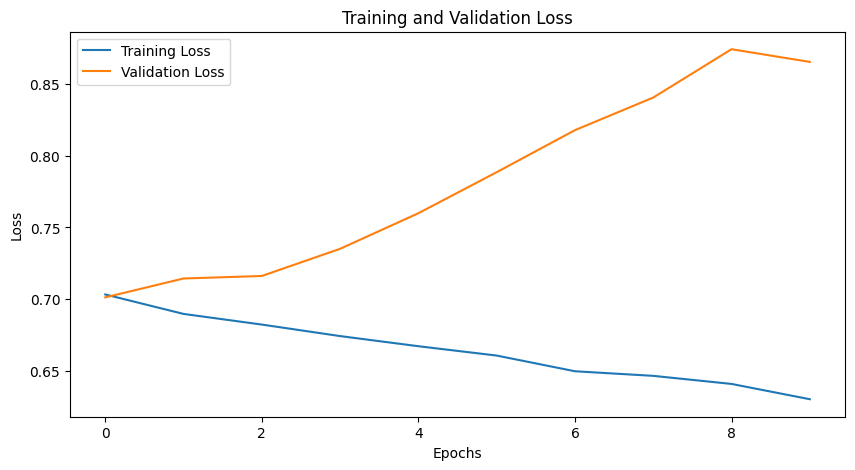


Test Results:
              precision    recall  f1-score   support

         0.0       0.43      0.35      0.39        51
         1.0       0.45      0.53      0.49        51

    accuracy                           0.44       102
   macro avg       0.44      0.44      0.44       102
weighted avg       0.44      0.44      0.44       102

Confusion Matrix:
[[18 33]
 [24 27]]


In [36]:
model = VulnerabilityLSTM(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=1
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop (Task 3)
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

# Evaluate on test set
test_loss, test_labels, test_preds = evaluate_model(model, test_loader, criterion)
print("\nTest Results:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

# Save model
torch.save(model.state_dict(), 'vulnerability_model.pth')

In [38]:
MAX_LEN_1 = 256           # Maximum sequence length
BATCH_SIZE_1 = 32         # Batch size
EMBEDDING_DIM_1 = 256     # Word embedding dimension
HIDDEN_DIM_1 = 256        # LSTM hidden dimension
EPOCHS_1 = 20             # Training epochs
LEARNING_RATE_1 = 0.001   # Learning rate

Starting training...
Epoch 1/10
Train Loss: 0.7147 | Val Loss: 0.6989
Epoch 2/10
Train Loss: 0.6871 | Val Loss: 0.7171
Epoch 3/10
Train Loss: 0.6757 | Val Loss: 0.7480
Epoch 4/10
Train Loss: 0.6698 | Val Loss: 0.7822
Epoch 5/10
Train Loss: 0.6522 | Val Loss: 0.8187
Epoch 6/10
Train Loss: 0.6408 | Val Loss: 0.8481
Epoch 7/10
Train Loss: 0.6340 | Val Loss: 0.9200
Epoch 8/10
Train Loss: 0.6156 | Val Loss: 0.9312
Epoch 9/10
Train Loss: 0.6024 | Val Loss: 1.0626
Epoch 10/10
Train Loss: 0.5922 | Val Loss: 1.0685
Epoch 11/10
Train Loss: 0.5794 | Val Loss: 1.1320
Epoch 12/10
Train Loss: 0.5646 | Val Loss: 1.2640
Epoch 13/10
Train Loss: 0.5664 | Val Loss: 1.3046
Epoch 14/10
Train Loss: 0.5556 | Val Loss: 1.2930
Epoch 15/10
Train Loss: 0.5444 | Val Loss: 1.3681
Epoch 16/10
Train Loss: 0.5307 | Val Loss: 1.5171
Epoch 17/10
Train Loss: 0.5366 | Val Loss: 1.4571
Epoch 18/10
Train Loss: 0.5333 | Val Loss: 1.5689
Epoch 19/10
Train Loss: 0.5277 | Val Loss: 1.4786
Epoch 20/10
Train Loss: 0.5244 | Val L

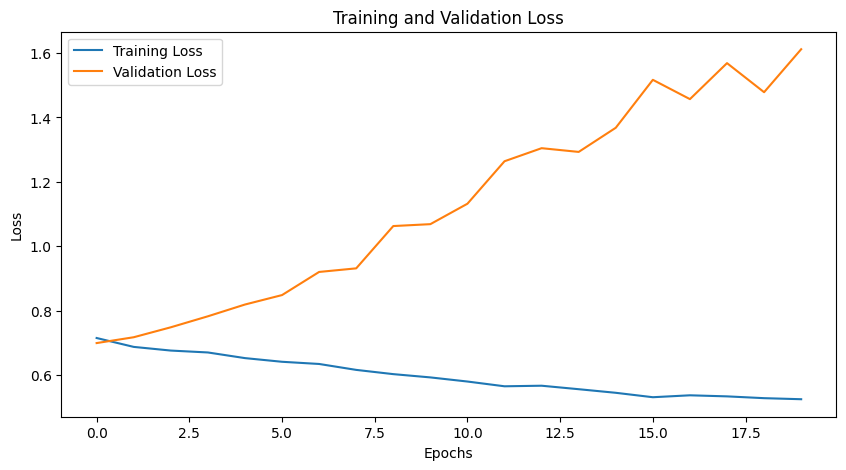


Test Results:
              precision    recall  f1-score   support

         0.0       0.38      0.35      0.37        51
         1.0       0.40      0.43      0.42        51

    accuracy                           0.39       102
   macro avg       0.39      0.39      0.39       102
weighted avg       0.39      0.39      0.39       102

Confusion Matrix:
[[18 33]
 [29 22]]


In [39]:
model = VulnerabilityLSTM(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM_1,
    hidden_dim=HIDDEN_DIM_1,
    output_dim=1
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_1)

# Training loop (Task 3)
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS_1):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

# Evaluate on test set
test_loss, test_labels, test_preds = evaluate_model(model, test_loader, criterion)
print("\nTest Results:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

# Save model
torch.save(model.state_dict(), 'vulnerability_model_1.pth')